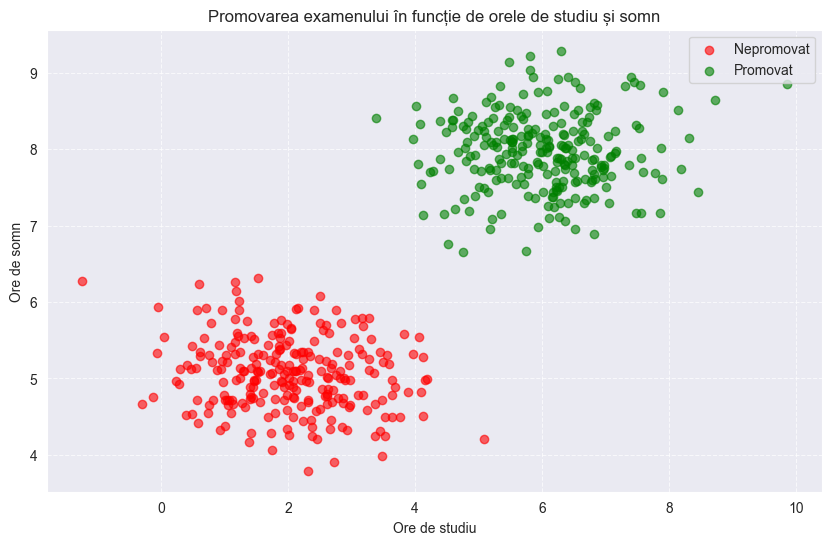

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Citirea datelor din fișierul CSV
data = pd.read_csv('date_promovare_examen.csv')

# Extragerea datelor
X_studiu = data['Ore_Studiu'].values  # Ore de studiu
X_somn = data['Ore_Somn'].values      # Ore de somn
y = data['Promovare'].values          # Rezultatul examenului

# Crearea graficului de dispersie
plt.figure(figsize=(10, 6))

# Plotarea punctelor pentru studenții nepromovați (y=0) cu roșu
plt.scatter(X_studiu[y==0], X_somn[y==0], 
           color='red', label='Nepromovat', alpha=0.6)

# Plotarea punctelor pentru studenții promovați (y=1) cu verde
plt.scatter(X_studiu[y==1], X_somn[y==1], 
           color='green', label='Promovat', alpha=0.6)

# Personalizarea graficului
plt.xlabel('Ore de studiu')
plt.ylabel('Ore de somn')
plt.title('Promovarea examenului în funcție de orele de studiu și somn')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Afișarea graficului
plt.show()

Datele par balansate. Continuam

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta_ore_studiu, beta_ore_somn]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 57 seconds.
There were 5792 divergences after tuning. Increase `target_accept` or reparameterize.


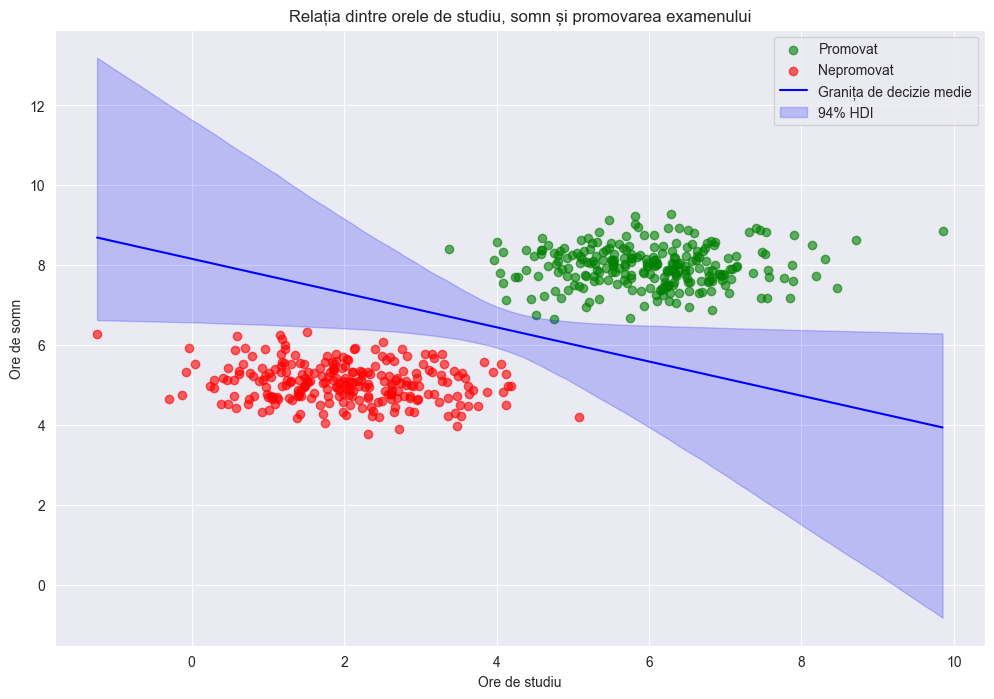

In [15]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

# Citirea datelor din fișierul CSV
data = pd.read_csv('date_promovare_examen.csv')

# Extragerea variabilelor predictoare (ore de studiu și somn) și variabila țintă (promovare)
X_studiu = data['Ore_Studiu'].values  # Ore de studiu pentru fiecare student
X_somn = data['Ore_Somn'].values      # Ore de somn pentru fiecare student
y = data['Promovare'].values          # Rezultatul examenului (1 = promovat, 0 = nepromovat)

# Standardizarea predictorilor pentru a îmbunătăți convergența modelului
# Standardizarea implică scăderea mediei și împărțirea la deviația standard
X_studiu_std = (X_studiu - X_studiu.mean()) / X_studiu.std()
X_somn_std = (X_somn - X_somn.mean()) / X_somn.std()

# Construirea modelului Bayesian folosind PyMC
with pm.Model() as model:
    # Definirea distribuțiilor a priori pentru coeficienți
    # Folosim distribuții normale cu medie 0 și deviație standard 10 (slab informative)
    beta0 = pm.Normal('beta0', mu=0, sigma=10)    # Termenul liber
    beta_ore_studiu = pm.Normal('beta_ore_studiu', mu=0, sigma=10)    # Coeficientul pentru ore de studiu
    beta_ore_somn = pm.Normal('beta_ore_somn', mu=0, sigma=10)    # Coeficientul pentru ore de somn
    
    # Calculul probabilității de promovare folosind funcția logistică
    logit_p = beta0 + beta_ore_studiu * X_studiu_std + beta_ore_somn * X_somn_std
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Definirea distribuției likelihood (Bernoulli pentru date binare)
    y_obs = pm.Bernoulli('y_obs', p=p, observed=y)
    
    # Eșantionarea din distribuția posterioară
    # 2000 de eșantioane după 1000 de iterații de warm-up
    trace = pm.sample(2000, tune=1000, return_inferencedata=True)

def calculate_decision_boundary(trace, X_studiu_mean, X_studiu_std, X_somn_mean, X_somn_std):
    """
    Calculează granița de decizie și intervalul HDI (Highest Density Interval)
    pentru vizualizarea regiunii de separare între promovare și nepromovare
    """
    beta0_samples = trace.posterior['beta0'].values.flatten()
    beta1_samples = trace.posterior['beta_ore_studiu'].values.flatten()
    beta2_samples = trace.posterior['beta_ore_somn'].values.flatten()
    
    studiu_range = np.linspace(X_studiu.min(), X_studiu.max(), 100)
    decision_boundaries = []
    
    # Calculul graniței de decizie pentru fiecare eșantion din distribuția posterioară
    for b0, b1, b2 in zip(beta0_samples, beta1_samples, beta2_samples):
        somn_boundary = -(b0 + b1 * ((studiu_range - X_studiu_mean) / X_studiu_std)) / b2
        somn_boundary = somn_boundary * X_somn_std + X_somn_mean
        decision_boundaries.append(somn_boundary)
    
    # Calculul mediei și intervalelor HDI
    mean_boundary = np.mean(decision_boundaries, axis=0)
    hdi_lower = np.percentile(decision_boundaries, 3, axis=0)
    hdi_upper = np.percentile(decision_boundaries, 97, axis=0)
    
    return studiu_range, mean_boundary, hdi_lower, hdi_upper

# Calculul graniței de decizie și a intervalului HDI
studiu_range, mean_boundary, hdi_lower, hdi_upper = calculate_decision_boundary(
    trace, X_studiu.mean(), X_studiu.std(), X_somn.mean(), X_somn.std()
)

# Crearea vizualizării rezultatelor
plt.figure(figsize=(12, 8))

# Plotarea punctelor pentru studenții promovați și nepromovați
plt.scatter(X_studiu[y==1], X_somn[y==1], c='green', label='Promovat', alpha=0.6)
plt.scatter(X_studiu[y==0], X_somn[y==0], c='red', label='Nepromovat', alpha=0.6)

# Plotarea graniței de decizie și a intervalului de încredere
plt.plot(studiu_range, mean_boundary, 'b-', label='Granița de decizie medie')
plt.fill_between(studiu_range, hdi_lower, hdi_upper, color='blue', alpha=0.2, label='94% HDI')

# Configurarea aspectului graficului
plt.xlabel('Ore de studiu')
plt.ylabel('Ore de somn')
plt.title('Relația dintre orele de studiu, somn și promovarea examenului')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
print(az.summary(trace, var_names=['beta0', 'beta_ore_studiu', 'beta_ore_somn']))


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta0   0.433  1.670  -2.596    3.637      0.049    0.035    1149.0    1250.0   
beta1   5.010  2.485   0.571    9.557      0.084    0.064     883.0    1066.0   
beta2  10.207  3.515   4.040   16.691      0.111    0.080    1001.0    1270.0   

       r_hat  
beta0   1.00  
beta1   1.01  
beta2   1.01  


beta_ore_studiu are in interval de 94% cu media aprox 5, si in acest interval, valoarea 0.000 nu este inclusa, deci orele de studiu sunt semnificative pentru prezicerea promovarii. beta_ore_somn are in interval de 94% cu media aprox 0.4, si in acest interval, valoarea 0.000 este inclusa, deci putem trage concluzia ca orele de somn nu sunt semnificative pentru prezicerea promovarii.